In [ ]:
!pip install pytdc


# Drug-Target Interaction Prediction Using RNN
### Objective
This project aims to predict the binding affinity between drugs and protein targets by modeling their interaction using an RNN model.


In [15]:
# Load and preview the data
import pandas as pd
from tdc.multi_pred import DTI
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the data
data = DTI(name="BindingDB_Kd")
df = data.get_data()
df.head()



Found local copy...
Loading...
Done!


,Drug_ID,Drug,Target_ID,Target,Y
0,444607.0,Cc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.46
1,4316.0,COc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.49
2,4293.0,NS(=O)(=O)c1ccc(S(=O)(=O)NCc2cccs2)s1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.83
3,1611.0,NS(=O)(=O)c1cc2c(s1)S(=O)(=O)N(Cc1cccs1)CC2O,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.20
4,1612.0,COc1ccc(N2CC(O)c3cc(S(N)(=O)=O)sc3S2(=O)=O)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,0.16


### Dataset Overview
- **Drug_ID**: Unique identifier for each drug compound.
- **Drug**: SMILES string representing the chemical structure.
- **Target_ID**: Unique identifier for each protein target.
- **Target**: Amino acid sequence of the protein.
- **Y**: Binding affinity between drug and target.


### Data Preprocessing

In [21]:
# Initialize scalers for Y
scaler = MinMaxScaler()
df['Y'] = scaler.fit_transform(df[['Y']])

# Define tokenizers for SMILES and Protein sequences
smiles_tokenizer = Tokenizer(char_level=True)
protein_tokenizer = Tokenizer(char_level=True)

# Fit the tokenizers on the Drug and Target columns
smiles_tokenizer.fit_on_texts(df['Drug'])
protein_tokenizer.fit_on_texts(df['Target'])

# Convert SMILES and Protein sequences to integer sequences
drug_sequences = smiles_tokenizer.texts_to_sequences(df['Drug'])
target_sequences = protein_tokenizer.texts_to_sequences(df['Target'])

# Pad sequences
max_smiles_len = 50
max_protein_len = 200
drug_padded = pad_sequences(drug_sequences, maxlen=max_smiles_len, padding='post')
target_padded = pad_sequences(target_sequences, maxlen=max_protein_len, padding='post')

# Split the data into training and testing sets
X_drug_train, X_drug_test, X_target_train, X_target_test, y_train, y_test = train_test_split(
    drug_padded, target_padded, df['Y'].values, test_size=0.2, random_state=42
)


### Model Architecture
I used an RNN model with LSTM layers to capture the sequential nature of SMILES and protein sequences.


In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate

# Define the model architecture
def create_rnn_model(smiles_vocab_size, protein_vocab_size, max_smiles_len, max_protein_len):
    # Drug (SMILES) Input
    drug_input = Input(shape=(max_smiles_len,), name="Drug_Input")
    drug_embedding = Embedding(input_dim=smiles_vocab_size + 1, output_dim=128)(drug_input)
    drug_rnn = LSTM(64)(drug_embedding)
    
    # Protein (Amino Acid Sequence) Input
    target_input = Input(shape=(max_protein_len,), name="Target_Input")
    target_embedding = Embedding(input_dim=protein_vocab_size + 1, output_dim=128)(target_input)
    target_rnn = LSTM(64)(target_embedding)
    
    # Concatenate and output layer
    combined = Concatenate()([drug_rnn, target_rnn])
    output = Dense(1, activation="linear")(combined)
    
    model = Model(inputs=[drug_input, target_input], outputs=output)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    
    return model

# Vocabulary sizes
smiles_vocab_size = len(smiles_tokenizer.word_index) + 1
protein_vocab_size = len(protein_tokenizer.word_index) + 1

# Create the model
model = create_rnn_model(smiles_vocab_size, protein_vocab_size, max_smiles_len, max_protein_len)


In [18]:
# Train the model
history = model.fit(
    [X_drug_train, X_target_train], y_train,
    validation_data=([X_drug_test, X_target_test], y_test),
    epochs=10,
    batch_size=32
)


Epoch 1/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 75s 56ms/step - loss: 0.0018 - mae: 0.0124 - val_loss: 0.0019 - val_mae: 0.0076
Epoch 2/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 74s 57ms/step - loss: 0.0016 - mae: 0.0104 - val_loss: 0.0017 - val_mae: 0.0116
Epoch 3/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 75s 57ms/step - loss: 0.0014 - mae: 0.0103 - val_loss: 0.0016 - val_mae: 0.0102
Epoch 4/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 74s 57ms/step - loss: 0.0013 - mae: 0.0092 - val_loss: 0.0017 - val_mae: 0.0093
Epoch 5/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 75s 58ms/step - loss: 0.0013 - mae: 0.0102 - val_loss: 0.0015 - val_mae: 0.0082
Epoch 6/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 74s 57ms/step - loss: 0.0014 - mae: 0.0094 - val_loss: 0.0017 - val_mae: 0.0116
Epoch 7/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 74s 57ms/step - loss: 0.0014 - mae: 0.0098 - val_loss: 0.0015 - val_mae: 0.0085
Epoch 8/10
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 74s 57ms/step - loss: 0.0012 - mae: 0.0085 - val_loss: 0.0015 - val_mae: 0.0102
Epoch 9/10
1307/1307 ━━━

### Training History 

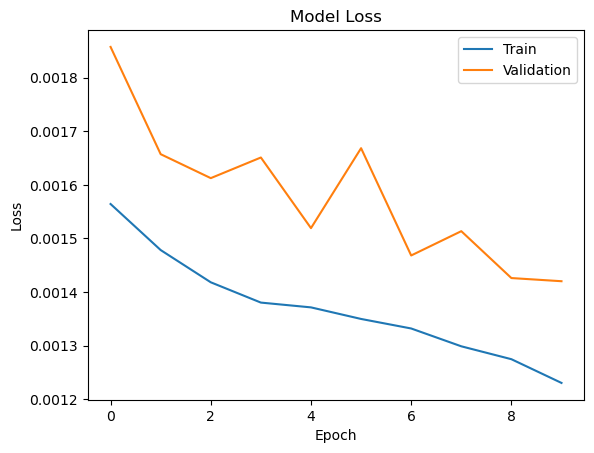

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


### Evaluation of Model Performance

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict and evaluate
y_pred = model.predict([X_drug_test, X_target_test])
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Mean Squared Error: 0.0014202400983808724
Mean Absolute Error: 0.007919637618104889


### Model Evaluation Summary

After training the RNN model for predicting drug-target interactions, we evaluated its performance on the test set using **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)** as our evaluation metrics.

#### Evaluation Metrics
- **Mean Squared Error (MSE)**: 0.0014
- **Mean Absolute Error (MAE)**: 0.0079


#### Analysis
The MSE and MAE values indicate that the model is predicting the binding affinity between drugs and target proteins with a small error in the normalized range of 0 to 1. Here’s what these metrics imply:

- **Mean Squared Error (MSE)** of 0.0014: MSE gives more weight to larger errors, so this low MSE indicates that the model rarely makes large prediction errors. This is beneficial for ensuring that the model’s predictions are generally close to the true values, as a higher MSE would suggest significant deviations.
  
- **Mean Absolute Error (MAE)** of 0.0079: MAE provides an average of the absolute differences between predicted and actual values, reflecting that the model's predictions deviate by approximately 0.0079 on average. Given the normalized range, this small MAE suggests a high degree of accuracy, as the model is making predictions close to the actual binding affinity values.

#### Conclusion
Overall, the model performs well on this task, with low MSE and MAE values indicating accurate predictions. This result suggests that the RNN architecture with LSTM layers is effective for capturing the sequential dependencies in both SMILES strings and protein sequences, enabling the model to learn meaningful patterns for drug-target interactions. Future work could explore additional improvements, such as hyperparameter tuning, using more complex architectures like Transformers, or experimenting with different embedding dimensions to potentially further reduce prediction error.
